https://arxiv.org/pdf/1511.06434.pdf

https://www.tensorflow.org/tutorials/generative/dcgan

https://www.machinecurve.com/index.php/2021/07/15/creating-dcgan-with-tensorflow-2-and-keras/


 Importing  libraries

In [ ]:
# Importing the required libraries

import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

We are loading fashion mnist data .The generator will generate fashion items resembling the fashion MNIST data.

In [ ]:
# here we use the Fashion MINST dataset
# we use only the training data
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images.shape

(60000, 28, 28)

 Reshaping the images to add one more dimension i.e Channel. As the images are gray-scale so Channel dimension will be 1. Also,Normalizing the images to [-1, 1]because the generator’s final layer activation uses tanh

In [ ]:
'''
- Neural networks works with batches of images
- Every image is represented in 3 dimensions -- Height, Width, Number of Channels
- Here we dont have the channel so we will add that by reshape method
- Since it is a grayscale image we set the number of channel as 1
'''
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [ ]:
train_images.shape
# here we observe that we have 60,000 images with each 28 x 28 pixels and 1 channel

(60000, 28, 28, 1)

Training set is prepared by dividing the whole data into batches and shuffling it.

In [ ]:
# Defining the batch and buffer size for shuffling the image
buffer_size = 60000
batch_size = 32 # here we have choosen smaller batch size instead of 128 as previous

In [ ]:
# using the tf dataset for loading data into batches
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size ).batch(batch_size)

Both the generator and discriminator are defined using the Keras Sequential API.

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28X28x1. Notice the tf.keras.layers.ReLU activation for each layer, except the output layer which uses tanh.

Blocks 2, 3 consist of a convolution transpose(upsampling) layer, followed by a batch-normalization layer and an activation function, ReLU.
The last block comprises no batch-normalization layer, with a sigmoid activation function.

Note that activation in final layer is tanh which outputs in the range -1 to 1.Code for GAN architecture is based on this link https://www.tensorflow.org/tutorials/generative/dcgan and the original paper link on  which architecture is based is here-https://arxiv.org/pdf/1511.06434.pdf

In [ ]:
def generator_model():
    model = tf.keras.Sequential()
    # the first layer in our generator model is fully connected dense layer
    # this layer has 7 x 7 x 256 neurons
    # we have specifically choosen these dimensions because in our Deep Convolutional GAN,
        # the input to our generator is a batch of noise vectors, that every vector has a
        # hundred elements, that's why the input shape here is 100
    # And we've hidden a batch of noise vectors, so the input is in two dimensions
    # and at the start of the convolution stack, this input is cast to four dimensions
    # Batch size is the 1st dimension and the remaining dimensions are 7 x 7 x 256
    # the output of this dense layer will be a flattened vector of 7 x 7 x 256
    model.add(layers.Dense(7 * 7 * 256, input_shape = (100, )))
    # then this vector is passed through a batch of normalization layer
    # The batch normalization layer will recenter our data to have a mean of zero and variants of one
    # at the same pass through a ReLU activation layer
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # and here is where we reshape the input to be in 4 dimensions
    # the batch is the first dimension and remaining 3 dimensions are 7 x 7 x 256
    # this is start of convolutional stack
    model.add(layers.Reshape((7, 7, 256)))

    # this reshaped data then pass through a number of transposed convolutional layers
    # remember these layers are from upsampling of the input data
    # Every transposed convolutional layer is followed by a batch normalization and ReLU activation function
    model.add(layers.Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Every Conv2DTranspose layer reshapes our data till the final Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Final layer
    # It produces an upsample image
    # This upsample image will be of the same size as the images from our real dataset
    # Every image will be 28 x 28 x 1
    # the tanh activation ensures that hte image pixel values are in the range of -1 to 1
    model.add(layers.Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', activation = 'tanh'))

    # In Deep Convolutional GAN, this generator model performs upsampling of the input data
    # from a noise vector which has a dimensionality of 100 to an actual generated image
    # and this network make use of strided convolutions to perform this upsampling

    return model

Building the generator model and summary is obtained

In [ ]:
# Summary of the Generator model
generator = generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819328    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

Using the (as yet untrained) generator to create an random colored image.

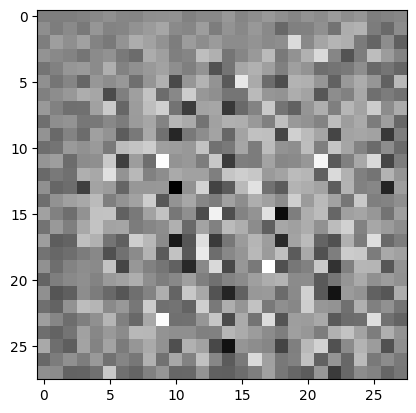

In [ ]:
# Lets check out the generated image
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)

plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')

# we got a random noise

The discriminator is a CNN-based image classifier.
Inputs an image of dimension 28 X 28 X 1
Outputs a score between 0 and 1(sigmoid activation in final layer)
Batch normalisation layer is applied for intermediate layers
Has Leaky-Relu (with a slope of 0.2) as an activation function in the intermediate layers along with dropout layers
Has a Sigmoid activation function in the output layer.Note that we can also leave the last layer without sigmoid activation and use_logits=True in Binary Cross entropy function(which is recommended but we have done it this way  for ease in calculating real and fake scores with their display)

In [ ]:
def discriminator_model():
    # the discriminator model is a classifier using a convolutional neural network
    # we built a sequential model, rather than using pooling layers we only use the
    # convolutional layers in this discriminator
    # Observe the input shape of an image, 28 x 28 x 1
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides = (2, 2), padding = 'same',
                            input_shape = [28, 28, 1]))

    # Convolutional layers are followed by batch normalization which reset the output
    # To have mean of 0 and variance of 1
    # the activation function works well in this discriminator is LeakyReLU
    # and it is followed by a Dropout layer to mitigate overfitting
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    # Here is an other block of layer with same architecture
        # Convolutional Layer
        # Batch Normalization
        # LealyReLU
        # Dropout
    model.add(layers.Conv2D(128, (5, 5), strides = (2, 2), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    # The final layer of discriminator flattens the input image and output probability score
    # This probability score is the probability that the input image is real
    # The sigmoid activation is what we usually use to output probabilities from out model
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

Building the discriminator model and summary is obtained

In [ ]:
# Discriminator Summary
discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                     

Here We are using  the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output values > 0.5  for real images, and values <0.5 for fake images.

In [ ]:
# Lets pass the untrained image from generator to see how the discriminator performs
discriminator = discriminator_model()
output = discriminator(generated_image)
print (output)

# we can see 50% score, means discriminator failed as we haven't trained yet

tf.Tensor([[0.50005156]], shape=(1, 1), dtype=float32)


Now We are defining loss functions. In this case it is Binary Cross entropy as target is real or fake images

In [ ]:
# Let's define the loss function
# we use Binary Cross Entropy
bce = tf.keras.losses.BinaryCrossentropy()

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
# Discriminator Loss

def discriminator_loss(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss

    return total_loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
# Generator Loss
def generator_loss(fake_output):
    gen_loss = bce(tf.ones_like(fake_output), fake_output)

    return gen_loss

The discriminator and the generator optimizers are different since  two networks would be trained separately.

In [ ]:
# we use the adam optimizer to update model parameters
# here the learning rate is 0.0002
# beta_1 --> which is the DKrate that we use to estimate the first moment of the adam optimizer is o.5
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

# we have explicitly choosen these parameters because these are parameters used in the original
# Deep convolutional GAN paper that published in 2016

Following code demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
# We setup a checkpoint folder for model training
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

We are using `tf.function`
This annotation causes the function to be "compiled".


In [ ]:
# We train for 50 epochs,
epochs = 50
# Noise vector that we feed into generator has dimensionality of 100
noise_dim = 100

# we use 16 examples to see how our generator improves for every epoch of training
num_examples_to_generate = 16

# the seed here is the test input to our generator, after every epoch set up the seed
# using a Gaussiam normal distribution for our latent noise variable
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Notice `training` is set to False.
This is so all layers run in inference mode (batchnorm).
Function for generating and saving images is defined

In [ ]:
# This function is a utility function that we use to plot generated images after every training epoch
def generate_and_plot_images(model, epoch, test_input):

    predictions = model(test_input, training = False)

    fig = plt.figure(figsize = (8, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        pred = (predictions[i, :, :, 0] + 1) * 127.5
        pred = np.array(pred)
        plt.imshow(pred.astype(np.uint8), cmap = 'gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
# here we have train_step function which is annodated with @tf.function
# So that tensorflow generates a graph for this particular neural network
@tf.function
def train_step(images):
  # Train step accepts one batch of images from the real dataset as the input
  # It then generates a corresponding batch of fake images using the generator
  # the real and fake images are then passed through the discriminator, we compute the generator loss and
  # discriminator loss, compute gradients for both generator and discriminator
  # and then use these gradients to update the parameters of the two adversaries
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

In [ ]:
# Here we have the train function, where we actually train 2 neural networks
# For every batch of data it invokes the train_step function that we saw earlier to perform the actual training
# It keep track of average generator and discriminator loss for every epoch of training
# It also keeps track of the accuracy of the discriminator overtime for real and fake images
def train(dataset, epochs):

    gen_loss_list = []
    disc_loss_list = []

    real_score_list = []
    fake_score_list = []

    for epoch in tqdm(range(epochs)): # for progress bar
        start = time.time()
        num_batches = len(dataset)

        print(f'Training started with  epoch {epoch + 1} with {num_batches} batches..')

        total_gen_loss = 0
        total_disc_loss = 0

        for batch in dataset:
            generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
            total_gen_loss += generator_loss
            total_disc_loss += discriminator_loss

        mean_gen_loss = total_gen_loss/num_batches
        mean_disc_loss = total_disc_loss/num_batches

        print('Losses after epoch %5d: generator %.3f, discriminator %.3f, real_score %.2f%%, fake_score %.2f%%' %
              (epoch + 1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

        generate_and_plot_images(generator, epoch + 1, seed)

        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)

        if (epoch + 1) % 10 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Once training is complete across all epochs and all batches, this function returns a list of
    # Generator losses, discriminator losses and scores of discriminator for real and fake images
    return  gen_loss_list, disc_loss_list, real_score_list, fake_score_list

Finally, it’s time to train our  GAN model in Tensorflow. Taking the train_dataset and epochs as the parameters, the  train function calls the train_step function, at every new batch.At the beginning of the training, the generated images look like random noise. As training progresses, the generated images will look more real.

  0%|          | 0/50 [00:00<?, ?it/s]

Training started with  epoch 1 with 1875 batches..
Losses after epoch     1: generator 2.038, discriminator 0.570, real_score 78.00%, fake_score 17.49%


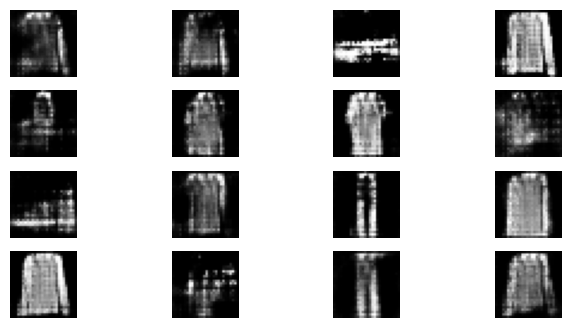

  2%|▏         | 1/50 [00:26<21:21, 26.16s/it]

Time for epoch 1 is 26.157731294631958 sec
Training started with  epoch 2 with 1875 batches..
Losses after epoch     2: generator 1.384, discriminator 1.310, real_score 49.24%, fake_score 33.08%


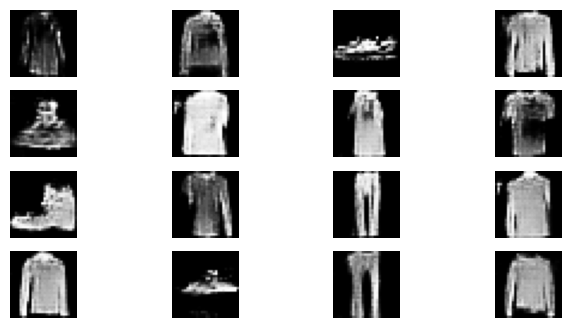

  4%|▍         | 2/50 [00:44<17:23, 21.74s/it]

Time for epoch 2 is 18.63831615447998 sec
Training started with  epoch 3 with 1875 batches..
Losses after epoch     3: generator 1.056, discriminator 1.488, real_score 44.09%, fake_score 39.78%


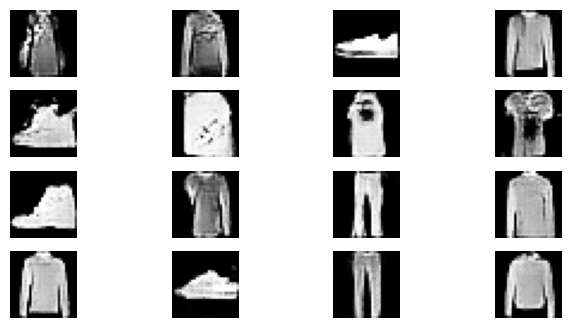

  6%|▌         | 3/50 [01:01<15:11, 19.40s/it]

Time for epoch 3 is 16.61786913871765 sec
Training started with  epoch 4 with 1875 batches..
Losses after epoch     4: generator 0.876, discriminator 1.268, real_score 60.09%, fake_score 45.70%


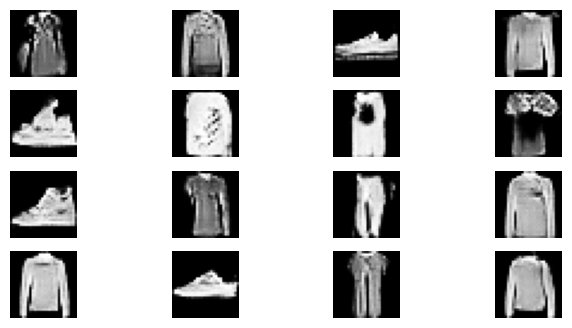

  8%|▊         | 4/50 [01:17<13:54, 18.14s/it]

Time for epoch 4 is 16.19029211997986 sec
Training started with  epoch 5 with 1875 batches..
Losses after epoch     5: generator 0.643, discriminator 1.353, real_score 63.79%, fake_score 54.90%


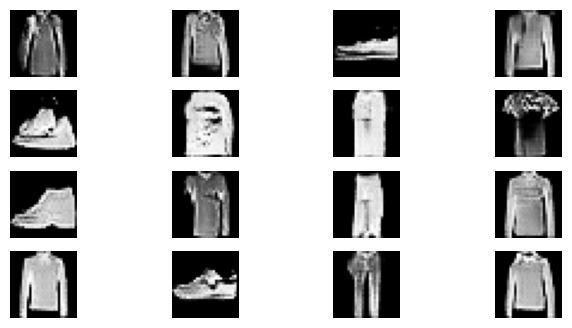

 10%|█         | 5/50 [01:35<13:29, 17.99s/it]

Time for epoch 5 is 17.7222638130188 sec
Training started with  epoch 6 with 1875 batches..
Losses after epoch     6: generator 0.995, discriminator 1.485, real_score 43.18%, fake_score 40.54%


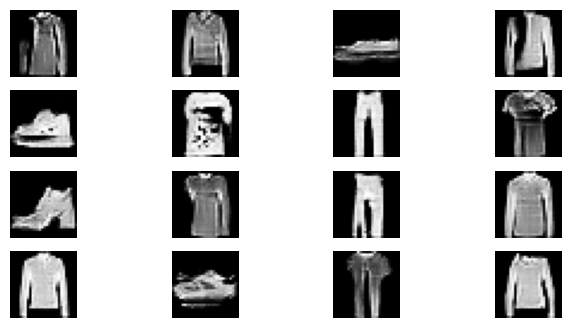

 12%|█▏        | 6/50 [01:57<14:10, 19.33s/it]

Time for epoch 6 is 21.929816722869873 sec
Training started with  epoch 7 with 1875 batches..
Losses after epoch     7: generator 0.904, discriminator 1.308, real_score 53.63%, fake_score 43.82%


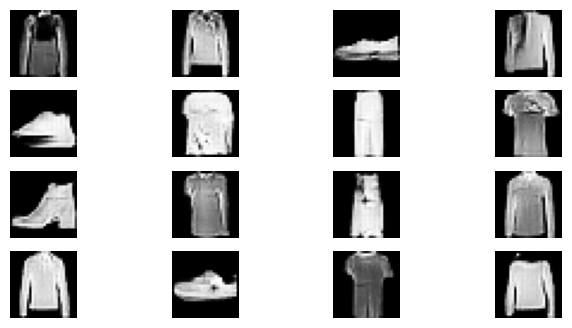

 14%|█▍        | 7/50 [02:15<13:42, 19.13s/it]

Time for epoch 7 is 18.70391821861267 sec
Training started with  epoch 8 with 1875 batches..
Losses after epoch     8: generator 0.869, discriminator 1.274, real_score 53.80%, fake_score 43.80%


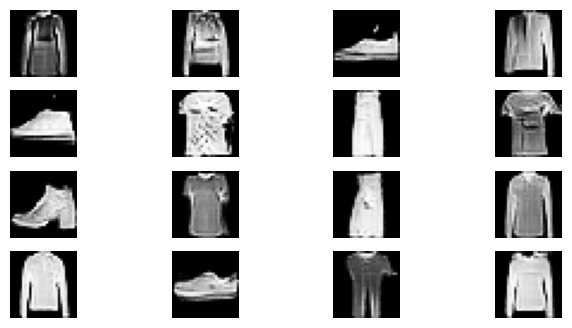

 16%|█▌        | 8/50 [02:34<13:13, 18.88s/it]

Time for epoch 8 is 18.36138343811035 sec
Training started with  epoch 9 with 1875 batches..
Losses after epoch     9: generator 0.721, discriminator 1.442, real_score 53.59%, fake_score 51.29%


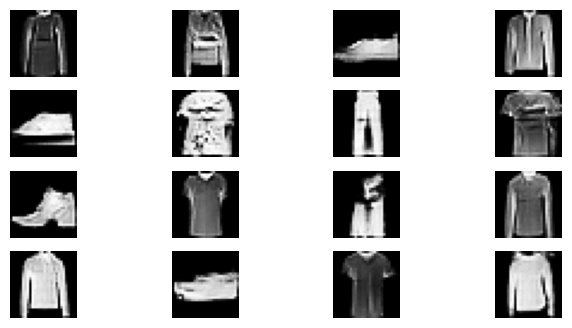

 18%|█▊        | 9/50 [02:53<12:55, 18.92s/it]

Time for epoch 9 is 18.99422788619995 sec
Training started with  epoch 10 with 1875 batches..
Losses after epoch    10: generator 0.838, discriminator 1.369, real_score 51.31%, fake_score 45.82%


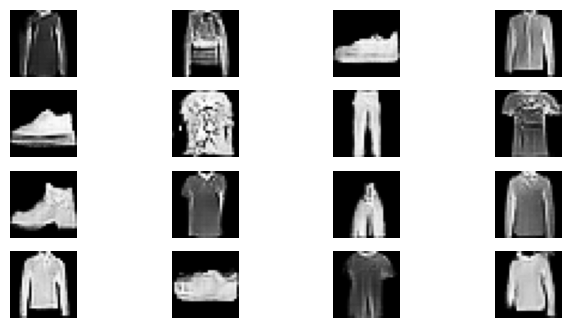

 20%|██        | 10/50 [03:15<13:12, 19.80s/it]

Time for epoch 10 is 21.76253867149353 sec
Training started with  epoch 11 with 1875 batches..
Losses after epoch    11: generator 0.865, discriminator 1.316, real_score 53.14%, fake_score 44.73%


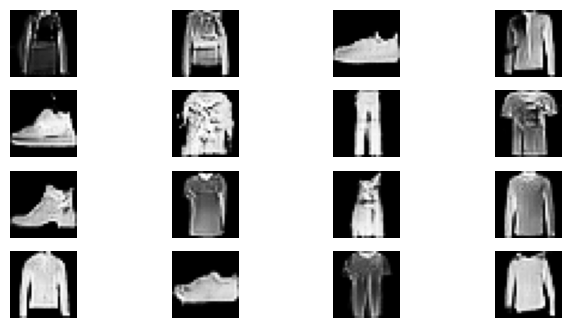

 22%|██▏       | 11/50 [03:34<12:51, 19.78s/it]

Time for epoch 11 is 19.719186544418335 sec
Training started with  epoch 12 with 1875 batches..
Losses after epoch    12: generator 0.833, discriminator 1.416, real_score 49.74%, fake_score 46.64%


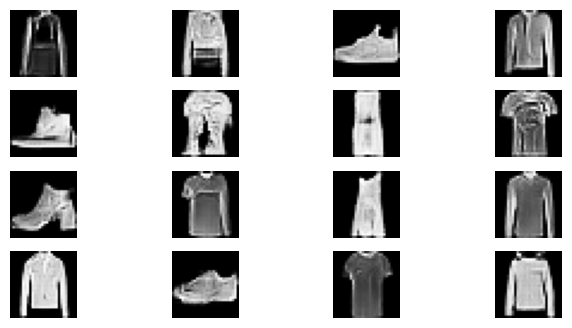

 24%|██▍       | 12/50 [03:56<12:56, 20.44s/it]

Time for epoch 12 is 21.95679211616516 sec
Training started with  epoch 13 with 1875 batches..
Losses after epoch    13: generator 0.819, discriminator 1.380, real_score 48.68%, fake_score 45.47%


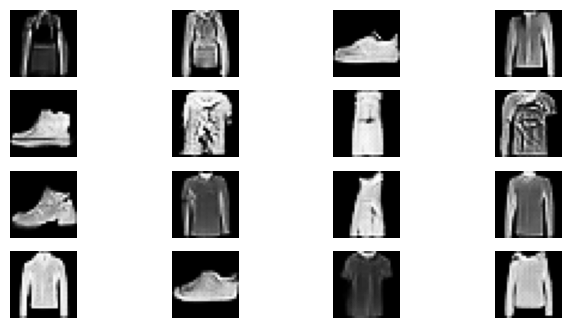

 26%|██▌       | 13/50 [04:16<12:23, 20.11s/it]

Time for epoch 13 is 19.32980251312256 sec
Training started with  epoch 14 with 1875 batches..
Losses after epoch    14: generator 0.791, discriminator 1.207, real_score 60.71%, fake_score 46.91%


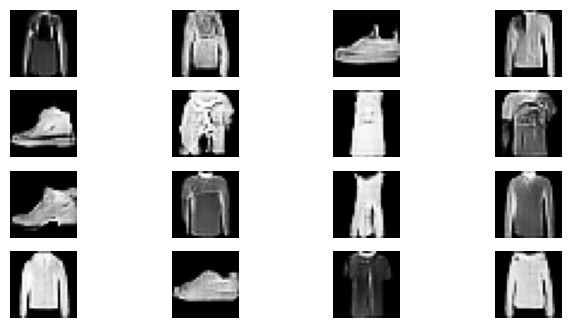

 28%|██▊       | 14/50 [04:34<11:49, 19.70s/it]

Time for epoch 14 is 18.76500368118286 sec
Training started with  epoch 15 with 1875 batches..
Losses after epoch    15: generator 0.640, discriminator 1.389, real_score 59.71%, fake_score 54.75%


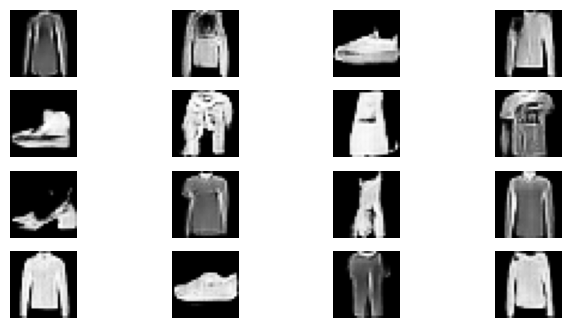

 30%|███       | 15/50 [04:56<11:47, 20.22s/it]

Time for epoch 15 is 21.416203260421753 sec
Training started with  epoch 16 with 1875 batches..
Losses after epoch    16: generator 0.812, discriminator 1.313, real_score 56.52%, fake_score 47.34%


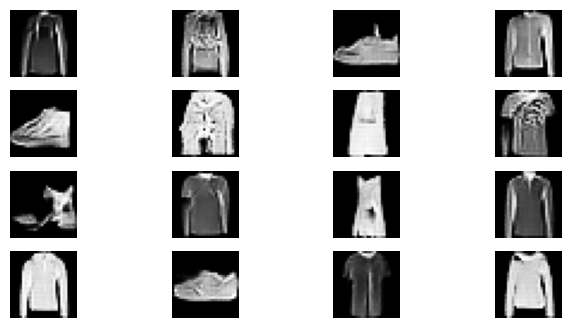

 32%|███▏      | 16/50 [05:13<11:00, 19.43s/it]

Time for epoch 16 is 17.577869653701782 sec
Training started with  epoch 17 with 1875 batches..
Losses after epoch    17: generator 0.805, discriminator 1.416, real_score 53.58%, fake_score 48.04%


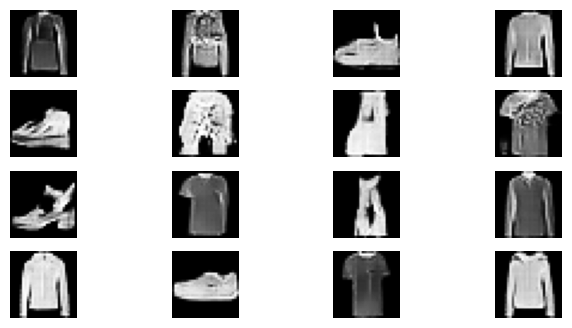

 34%|███▍      | 17/50 [05:35<11:00, 20.00s/it]

Time for epoch 17 is 21.34947633743286 sec
Training started with  epoch 18 with 1875 batches..
Losses after epoch    18: generator 1.037, discriminator 1.038, real_score 58.73%, fake_score 37.01%


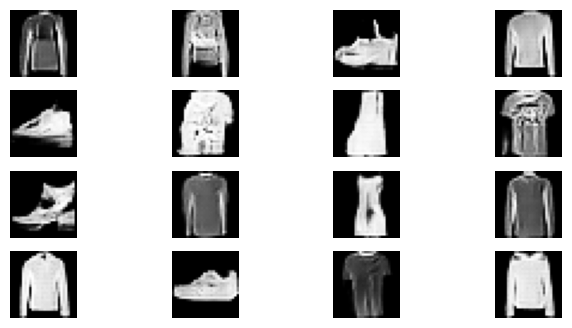

 36%|███▌      | 18/50 [05:54<10:34, 19.83s/it]

Time for epoch 18 is 19.40290927886963 sec
Training started with  epoch 19 with 1875 batches..
Losses after epoch    19: generator 0.901, discriminator 1.339, real_score 51.23%, fake_score 44.07%


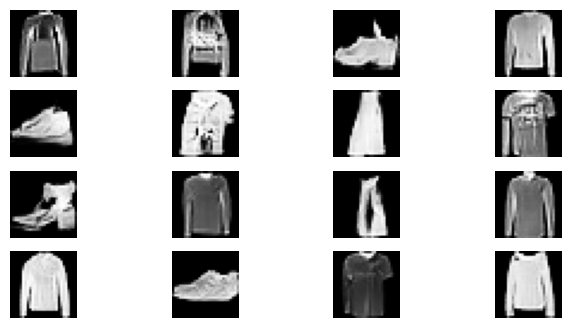

 38%|███▊      | 19/50 [06:15<10:25, 20.17s/it]

Time for epoch 19 is 20.98183584213257 sec
Training started with  epoch 20 with 1875 batches..
Losses after epoch    20: generator 0.911, discriminator 1.206, real_score 57.12%, fake_score 42.60%


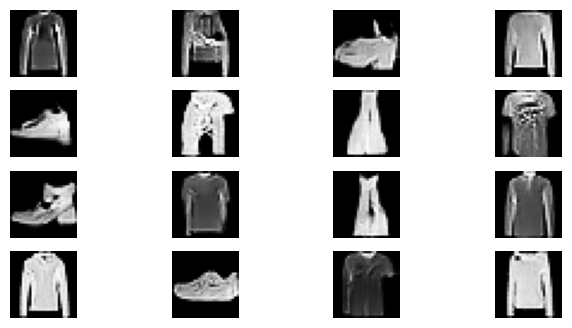

 40%|████      | 20/50 [06:34<09:54, 19.80s/it]

Time for epoch 20 is 18.937567710876465 sec
Training started with  epoch 21 with 1875 batches..
Losses after epoch    21: generator 0.794, discriminator 1.327, real_score 53.93%, fake_score 47.19%


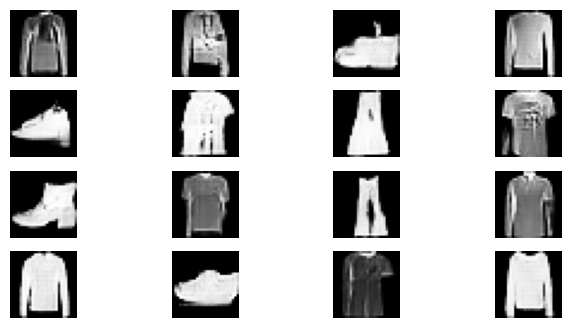

 42%|████▏     | 21/50 [06:50<09:01, 18.66s/it]

Time for epoch 21 is 16.005186319351196 sec
Training started with  epoch 22 with 1875 batches..
Losses after epoch    22: generator 0.894, discriminator 1.140, real_score 61.45%, fake_score 43.48%


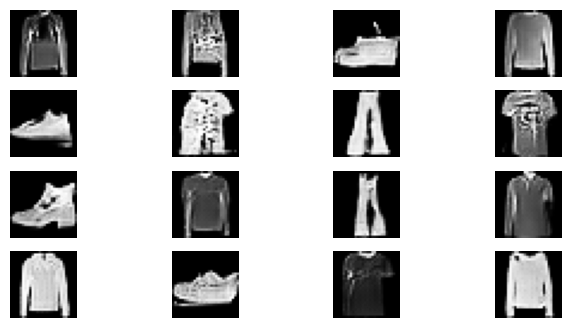

 44%|████▍     | 22/50 [07:06<08:17, 17.78s/it]

Time for epoch 22 is 15.711534023284912 sec
Training started with  epoch 23 with 1875 batches..
Losses after epoch    23: generator 0.814, discriminator 1.467, real_score 48.21%, fake_score 47.09%


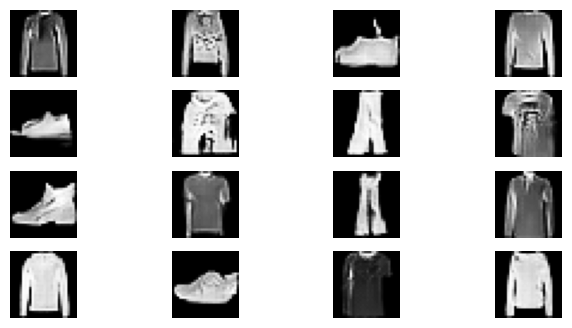

 46%|████▌     | 23/50 [07:22<07:44, 17.19s/it]

Time for epoch 23 is 15.807851791381836 sec
Training started with  epoch 24 with 1875 batches..
Losses after epoch    24: generator 0.828, discriminator 1.126, real_score 63.23%, fake_score 45.38%


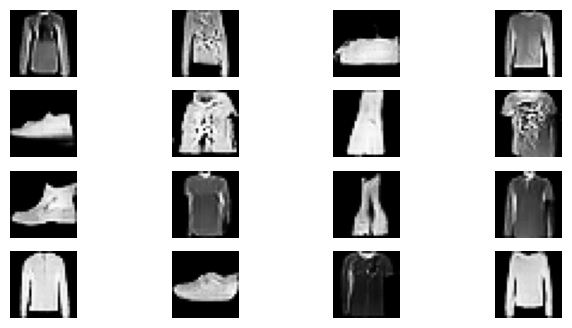

 48%|████▊     | 24/50 [07:37<07:14, 16.72s/it]

Time for epoch 24 is 15.629501819610596 sec
Training started with  epoch 25 with 1875 batches..
Losses after epoch    25: generator 0.842, discriminator 1.193, real_score 60.65%, fake_score 46.34%


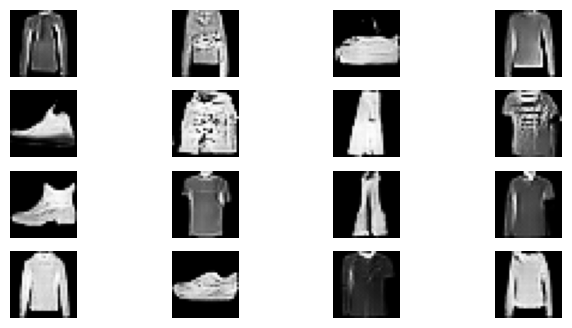

 50%|█████     | 25/50 [07:53<06:48, 16.34s/it]

Time for epoch 25 is 15.439528942108154 sec
Training started with  epoch 26 with 1875 batches..
Losses after epoch    26: generator 0.775, discriminator 1.284, real_score 58.93%, fake_score 48.49%


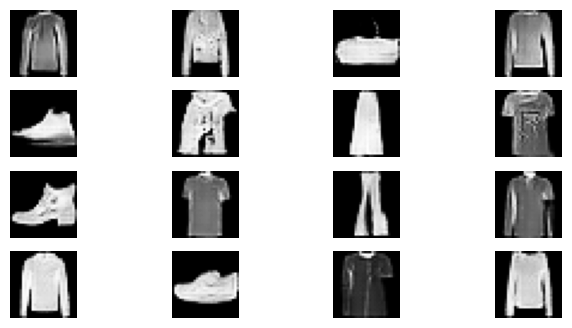

 52%|█████▏    | 26/50 [08:08<06:28, 16.17s/it]

Time for epoch 26 is 15.767159223556519 sec
Training started with  epoch 27 with 1875 batches..
Losses after epoch    27: generator 0.723, discriminator 1.242, real_score 63.85%, fake_score 51.04%


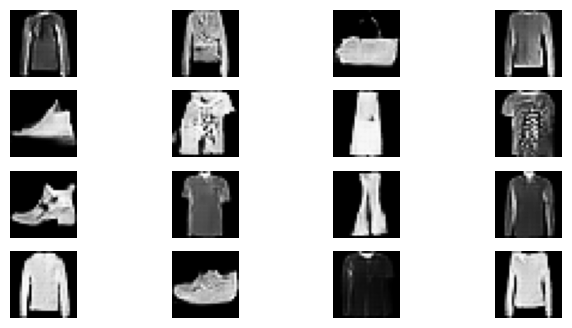

 54%|█████▍    | 27/50 [08:24<06:07, 15.96s/it]

Time for epoch 27 is 15.457098722457886 sec
Training started with  epoch 28 with 1875 batches..
Losses after epoch    28: generator 0.634, discriminator 1.459, real_score 57.62%, fake_score 55.61%


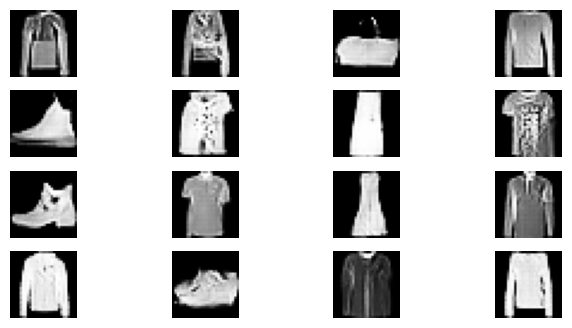

 56%|█████▌    | 28/50 [08:39<05:47, 15.82s/it]

Time for epoch 28 is 15.478201866149902 sec
Training started with  epoch 29 with 1875 batches..
Losses after epoch    29: generator 1.090, discriminator 1.248, real_score 49.12%, fake_score 36.50%


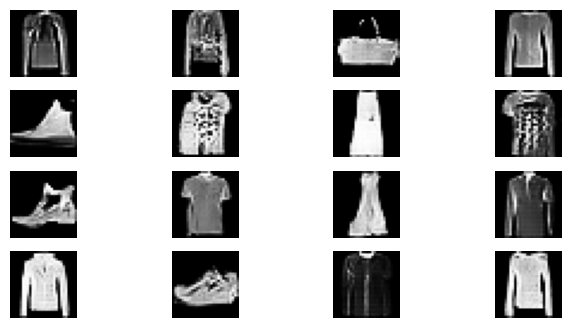

 58%|█████▊    | 29/50 [09:00<06:04, 17.37s/it]

Time for epoch 29 is 20.97798252105713 sec
Training started with  epoch 30 with 1875 batches..
Losses after epoch    30: generator 1.063, discriminator 1.392, real_score 44.25%, fake_score 37.58%


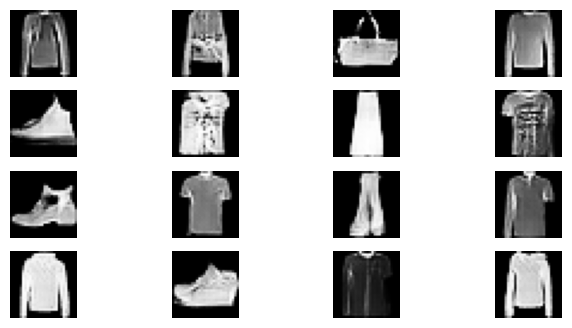

 60%|██████    | 30/50 [09:16<05:38, 16.95s/it]

Time for epoch 30 is 15.962186098098755 sec
Training started with  epoch 31 with 1875 batches..
Losses after epoch    31: generator 0.985, discriminator 1.161, real_score 56.31%, fake_score 40.15%


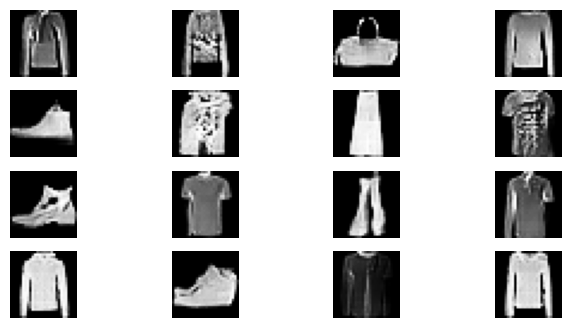

 62%|██████▏   | 31/50 [09:32<05:14, 16.55s/it]

Time for epoch 31 is 15.63821792602539 sec
Training started with  epoch 32 with 1875 batches..
Losses after epoch    32: generator 0.958, discriminator 1.305, real_score 48.69%, fake_score 40.44%


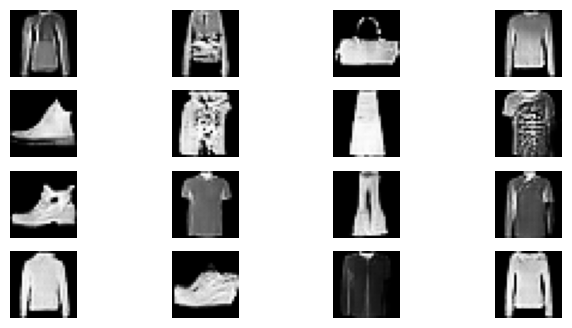

 64%|██████▍   | 32/50 [09:48<04:55, 16.43s/it]

Time for epoch 32 is 16.11320948600769 sec
Training started with  epoch 33 with 1875 batches..
Losses after epoch    33: generator 0.868, discriminator 1.261, real_score 55.48%, fake_score 45.43%


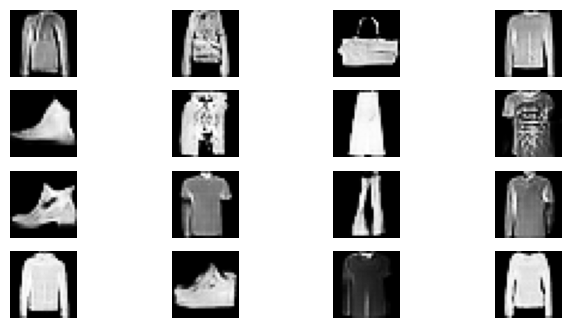

 66%|██████▌   | 33/50 [10:04<04:37, 16.31s/it]

Time for epoch 33 is 16.02918243408203 sec
Training started with  epoch 34 with 1875 batches..
Losses after epoch    34: generator 0.757, discriminator 1.375, real_score 55.69%, fake_score 50.21%


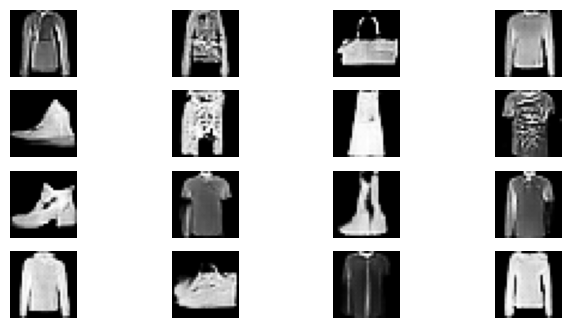

 68%|██████▊   | 34/50 [10:20<04:16, 16.04s/it]

Time for epoch 34 is 15.415975570678711 sec
Training started with  epoch 35 with 1875 batches..
Losses after epoch    35: generator 0.610, discriminator 1.659, real_score 51.03%, fake_score 57.09%


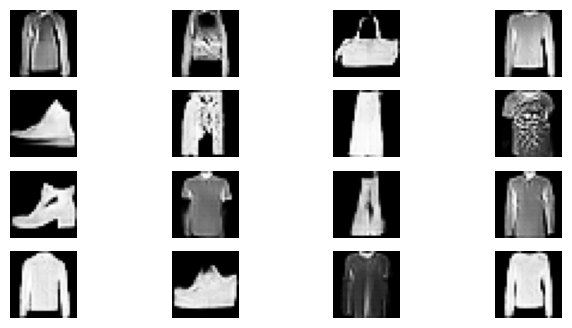

 70%|███████   | 35/50 [10:35<03:58, 15.92s/it]

Time for epoch 35 is 15.651989936828613 sec
Training started with  epoch 36 with 1875 batches..
Losses after epoch    36: generator 0.927, discriminator 1.161, real_score 56.19%, fake_score 41.70%


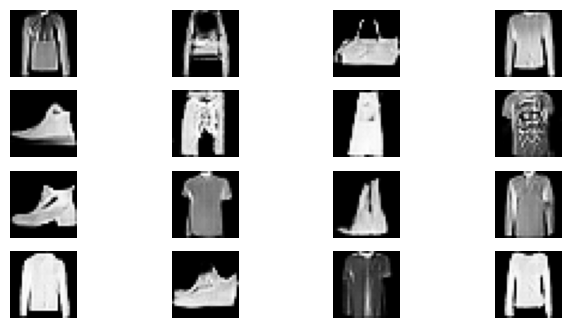

 72%|███████▏  | 36/50 [10:51<03:41, 15.79s/it]

Time for epoch 36 is 15.476529121398926 sec
Training started with  epoch 37 with 1875 batches..
Losses after epoch    37: generator 0.872, discriminator 1.424, real_score 47.32%, fake_score 44.55%


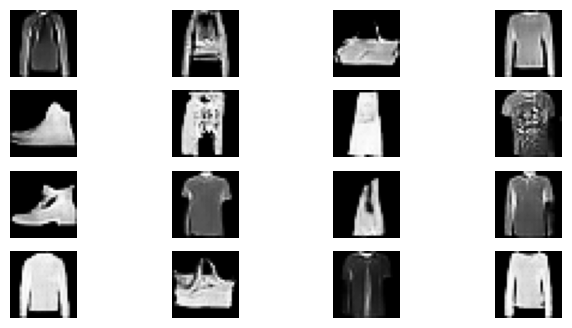

 74%|███████▍  | 37/50 [11:06<03:24, 15.74s/it]

Time for epoch 37 is 15.627084970474243 sec
Training started with  epoch 38 with 1875 batches..
Losses after epoch    38: generator 0.974, discriminator 1.057, real_score 62.18%, fake_score 40.81%


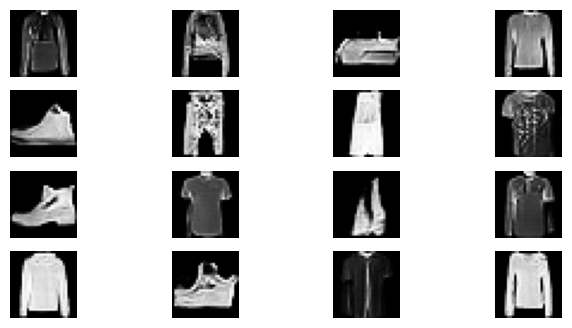

 76%|███████▌  | 38/50 [11:27<03:27, 17.31s/it]

Time for epoch 38 is 20.958593606948853 sec
Training started with  epoch 39 with 1875 batches..
Losses after epoch    39: generator 0.840, discriminator 1.273, real_score 54.70%, fake_score 44.91%


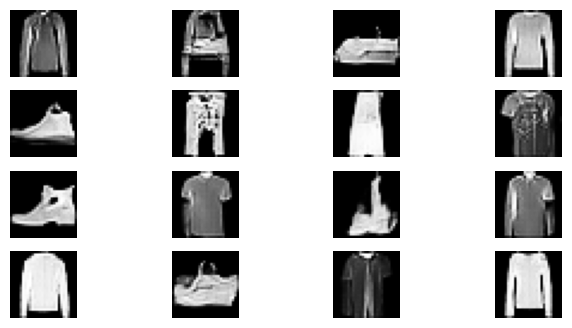

 78%|███████▊  | 39/50 [11:43<03:05, 16.84s/it]

Time for epoch 39 is 15.73763108253479 sec
Training started with  epoch 40 with 1875 batches..
Losses after epoch    40: generator 0.876, discriminator 1.293, real_score 52.18%, fake_score 43.63%


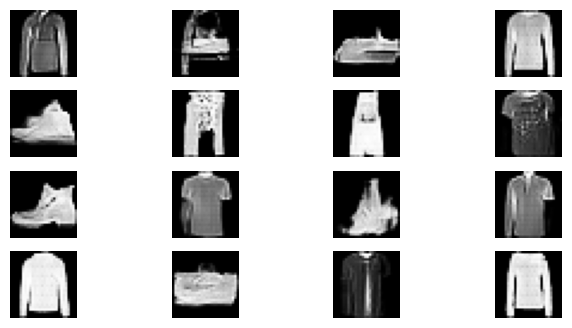

 80%|████████  | 40/50 [11:59<02:45, 16.50s/it]

Time for epoch 40 is 15.720354795455933 sec
Training started with  epoch 41 with 1875 batches..
Losses after epoch    41: generator 0.790, discriminator 1.287, real_score 55.62%, fake_score 47.23%


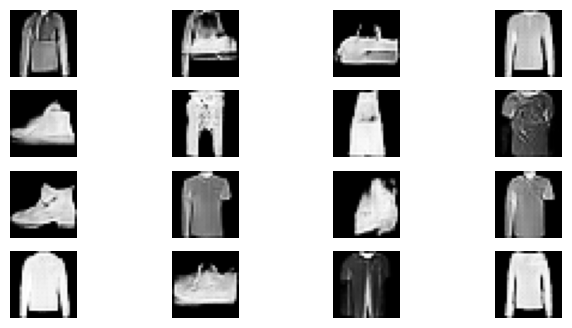

 82%|████████▏ | 41/50 [12:15<02:27, 16.37s/it]

Time for epoch 41 is 16.043177366256714 sec
Training started with  epoch 42 with 1875 batches..
Losses after epoch    42: generator 0.790, discriminator 1.066, real_score 68.18%, fake_score 46.83%


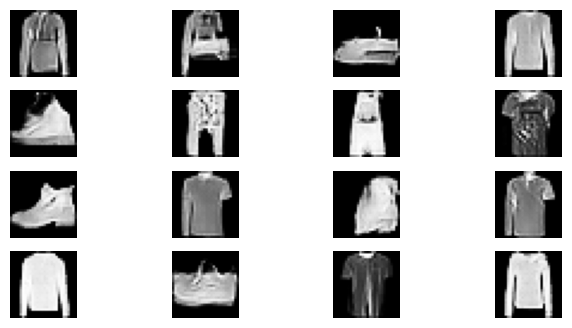

 84%|████████▍ | 42/50 [12:30<02:08, 16.10s/it]

Time for epoch 42 is 15.475483179092407 sec
Training started with  epoch 43 with 1875 batches..
Losses after epoch    43: generator 0.906, discriminator 1.194, real_score 57.05%, fake_score 43.52%


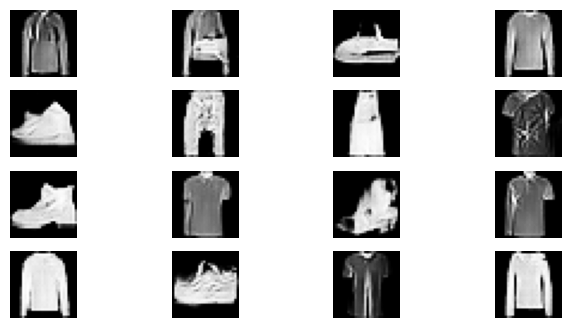

 86%|████████▌ | 43/50 [12:46<01:51, 15.95s/it]

Time for epoch 43 is 15.597832202911377 sec
Training started with  epoch 44 with 1875 batches..
Losses after epoch    44: generator 0.910, discriminator 1.381, real_score 47.77%, fake_score 43.07%


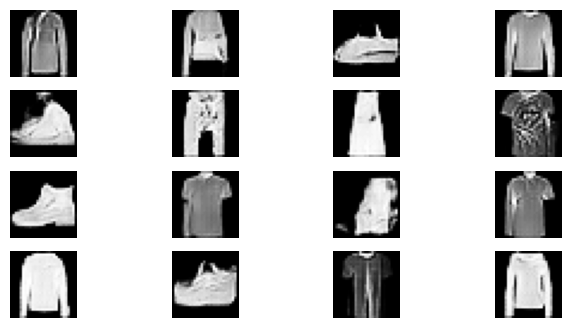

 88%|████████▊ | 44/50 [13:01<01:34, 15.79s/it]

Time for epoch 44 is 15.41342544555664 sec
Training started with  epoch 45 with 1875 batches..
Losses after epoch    45: generator 0.878, discriminator 1.302, real_score 53.65%, fake_score 43.78%


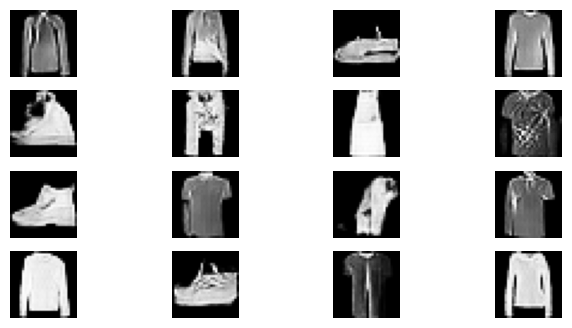

 90%|█████████ | 45/50 [13:17<01:18, 15.69s/it]

Time for epoch 45 is 15.452459812164307 sec
Training started with  epoch 46 with 1875 batches..
Losses after epoch    46: generator 0.947, discriminator 1.183, real_score 57.34%, fake_score 41.60%


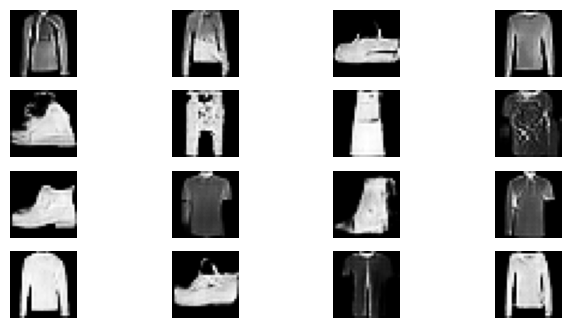

 92%|█████████▏| 46/50 [13:33<01:03, 15.77s/it]

Time for epoch 46 is 15.946452379226685 sec
Training started with  epoch 47 with 1875 batches..
Losses after epoch    47: generator 0.819, discriminator 1.319, real_score 56.65%, fake_score 47.52%


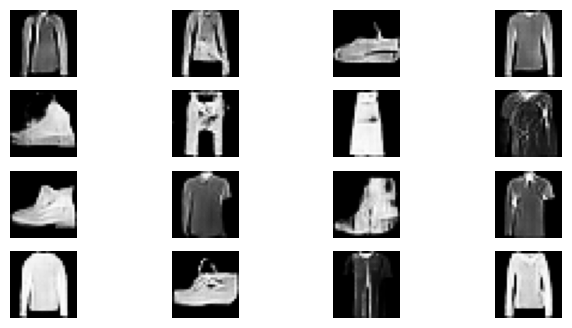

 94%|█████████▍| 47/50 [13:49<00:47, 15.90s/it]

Time for epoch 47 is 16.195104837417603 sec
Training started with  epoch 48 with 1875 batches..
Losses after epoch    48: generator 1.139, discriminator 1.284, real_score 45.96%, fake_score 34.76%


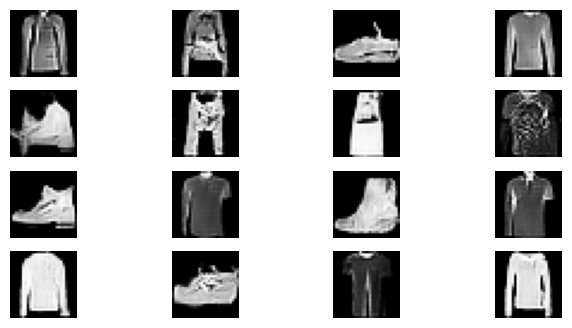

 96%|█████████▌| 48/50 [14:04<00:31, 15.76s/it]

Time for epoch 48 is 15.444957733154297 sec
Training started with  epoch 49 with 1875 batches..
Losses after epoch    49: generator 0.774, discriminator 1.408, real_score 51.46%, fake_score 48.23%


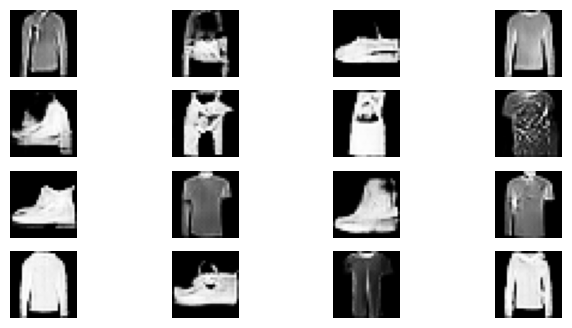

 98%|█████████▊| 49/50 [14:20<00:15, 15.66s/it]

Time for epoch 49 is 15.431437492370605 sec
Training started with  epoch 50 with 1875 batches..
Losses after epoch    50: generator 0.992, discriminator 1.220, real_score 53.57%, fake_score 40.23%


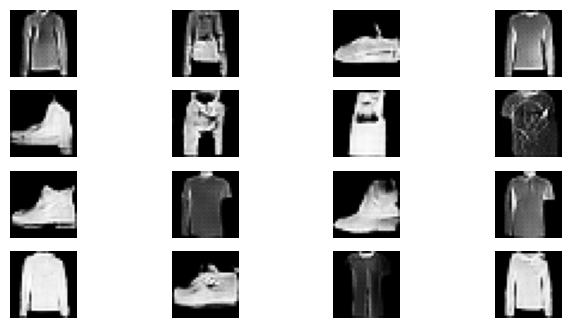

100%|██████████| 50/50 [14:35<00:00, 17.52s/it]

Time for epoch 50 is 15.593270063400269 sec


In [ ]:
'''
- The 2016 paper on Deep convolutional GANs showed that it performed better than GANs built using
  dense neural networks
- Let's train the DCGAN
- here we are passing the training dataset and number of epochs
'''

gen_loss_epochs, disc_loss_epochs,real_score_list,fake_score_list = train(train_dataset, epochs = epochs)

# within our first epoch we able to see the generated images which is pretty good

Real and fake scores both converge towards 0.5. This means that the discriminator is unable to differentiate between real and fake images. It has a 50% chance of getting classifications right (or wrong)

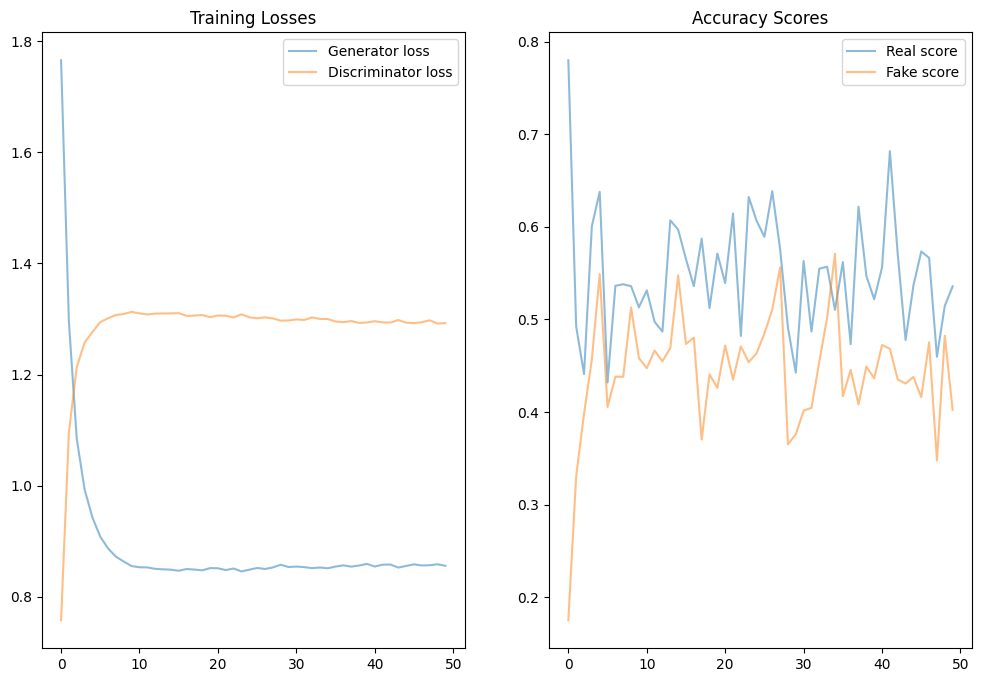

In [ ]:
# Lets check out the generator loss, discriminator loss and
# scores of the discriminator for real and fake data

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12,8))

ax1.plot(gen_loss_epochs, label = 'Generator loss', alpha = 0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha = 0.5)
ax1.legend()
ax1.set_title('Training Losses')
ax2.plot(real_score_list, label = 'Real score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()

# as we see here these graphs have lot of  interesting information to convey
# # Let's look at the generator loss which falls dramaticallyafter few epochs of training
    ## It shows that the generator clearly is getting better over time
## At the beginning of training the discriminator is distinguish between real and fake image easily
    ## its loss is loe
      ## but after few epochs of training the discriminator loss shoots up


# The accuracy scores of discriminator for real and fake image is more interesting
  # we able to observe that both of these score are converging at 50%
  # this means the discriminator at end of our training is unable to distinguish between real and fake data
  # which is exactly what we are looking for